In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import TruncatedSVD

plt.style.use('ggplot')

%matplotlib inline

# The Singular Value Decomposition

## Matrix Factorizations

In mathematics, it is often very fruitful to decompose complicated objects into simpler ones.  To accomplish this, we need a sense of two things:

- What exactle is a **simple object**?
- How do we combine two objects into another one?

### Prime Factorizations: Integers

To understand **integers** we can use the prime factorization.  Simple integers are taken to be prime numbers, and combination is taken to be multiplication of integers.

The outcome of this study is a famous theorem:

#### The Fundamental Theorem of Arithmetic

> Every integer can be written as a product of prime numbers in one and only one way (up to rearrangement of the product).

### Prime Factorizations: Polynomials

Polynomials can also be multiplied, and so they can be factored.  There is a theorem that is much like the fundamental theorem of arithmetic, but for polynomials:

#### The Fundamental Theorem of Algebra

Every polynomial can be factored in one and only one way into a product of linear polynomials.

$$ p(x) = (x - a_1) (x - a_2) \cdots (x - a_n) $$

where the $a_i$ may be complex numbers.

**Question**: Do you think there is a prime factorization theorem for matricies?

## The Singular Value Decomposition

Matricies are much more complicated objects than integers and ploynomials, there is not one single way to factor a matrix.  Instead, there are many matrix factorizations that have been invented to solve different types of problems.  [This wikipedia page](https://en.wikipedia.org/wiki/Matrix_decomposition) has an overview of the ecosystem.

The matrix factorization we will study today is called the **singular value decomposition** (SVD).

**Any** $n \times p$ matrix $X$ can be factored as follows

$$ X = U S V $$

Where

  - $U$ is a $n \times n$ orthogonal matrix.
  - $S$ is a $n \times p$ matrix with non-zero entries on the diagonal *only*.
  - $V$ is a $p \times p$ orthogonal matrix.

### Intermission: Orthogonal Matricies

An **orthogonal matrix** is one with the following property:
    
> Any vector $v$, when multiplied by an orthogonal matrix, is simply rotated (i.e. its length does not change).

We say that an orthogonal matrix **acts as a rotation**.

It's easy to crate $2 \times 2$ orthogonal matricies.  For any angle $\theta$, the matrix

$$ M_{\theta} =  \left( \begin{array}{cc} 
\cos \theta & - \sin \theta  \\       
sin \theta & cos \theta \\
\end{array} \right) $$

is orthogonal.  

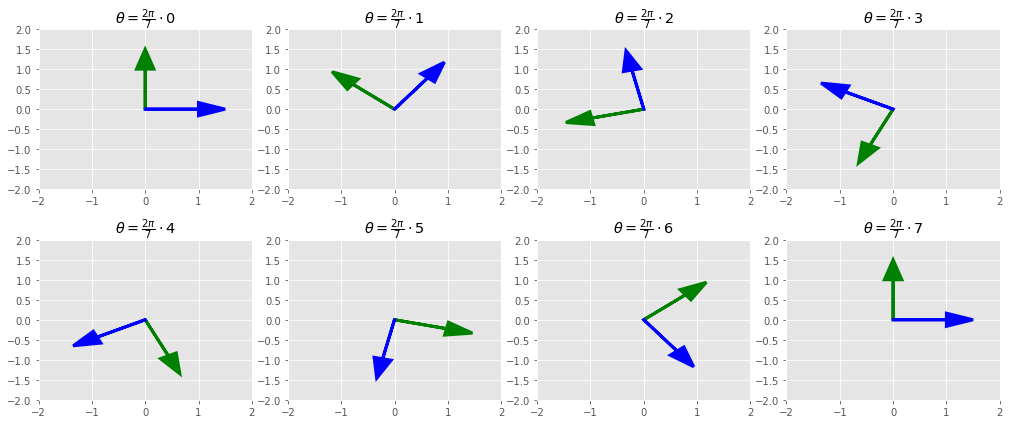

In [2]:
thetas = np.linspace(0, 2*np.pi, num=8)
coord_vectors = np.array([[1, 0], [0, 1]])


fig, axs = plt.subplots(2, 4, figsize=(14, 6))

for i, (theta, ax) in enumerate(zip(thetas, axs.flatten())):
    M = np.array([[-np.sin(theta), np.cos(theta)], 
                  [np.cos(theta), np.sin(theta)]])
    image_vectors = np.dot(M, coord_vectors)
    ax.arrow(0, 0, image_vectors[0, 0], image_vectors[1, 0],
            head_width=0.33, linewidth=3, head_length=0.5, fc='g', ec='g')
    ax.arrow(0, 0, image_vectors[0, 1], image_vectors[1, 1],
            head_width=0.33, linewidth=3, head_length=0.5, fc='b', ec='b')
    ax.set_title("$\\theta = \\frac{{2\\pi}}{{7}} \\cdot {}$".format(i))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
plt.tight_layout()

A closely related, and more common, definition of an orthogonal matrix is the following:
    
> An orthogonal matrix $M$ is any matrix satisfying the equation $M^t M = I$.

**Exercise**: Verify that the $2 \times 2$ matrix of sins and cosines above is orthogonal by computing $M_{\theta}^t M_{\theta}$ and using some basic trigonometric identities.

So the SVD ddecomposition:
    
$$ X = U S V $$

factors $X$ as three matricies:
    
  - $V$ is orthogonal, hence a rotation, followed by...
  - $S$ is quasi diagonal, so a scaling, followed by...
  - $U$ is orthogonal, so a rotation.

![SVD decomposition](img/svd.png)

Image Source: https://en.wikipedia.org/wiki/Singular_value_decomposition

The $S$ matrix has positive diagonal entries, these are called the **singular values** of $X$, they are closely related to eigenvalues.

So, for a $4 \times 2$ matrix $X$, the singular value matrix would look like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0  \\       
0 & \sigma_2 \\
0 & 0 \\
0 & 0 \\
\end{array} \right) $$

and for a $6 \times 3$ like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$

### Example: Image Reconstruction From Singular Values

Recall how we used PCA to "approximately reconstruct" a matrix $M$ from its first few principal components.  We can do the same thing with SVD

$$ X \approx U S_{k} V $$

Here, $S_{k}$ is the matrix created from $S$ by setting **all but the first $k$ singular values to zero**.

In an earlier example we reconstructed faces with only the first few principal components, here we reconstruct a face with only the first few **singular values**.

In [3]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

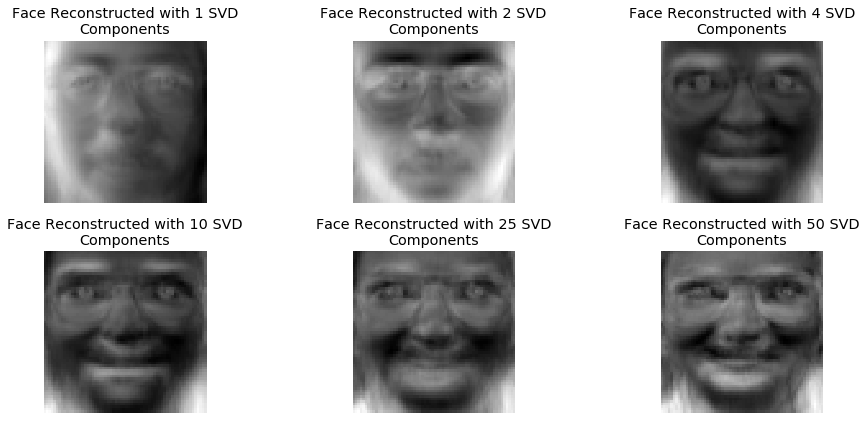

In [4]:
ig, axs = plt.subplots(2, 3, figsize=(13, 6))
U, S, VT = svd(faces_centered)

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    S_reduced = np.zeros(faces_centered.shape)
    np.fill_diagonal(S_reduced, S)
    # Set all but first dim singular values equal to zero.
    S_reduced[:, dim:] = 0
    faces_reconstructed = np.dot(U, np.dot(S_reduced, VT))
    first_face_reconstructed = faces_reconstructed[0].reshape(image_shape)
    ax.imshow(first_face_reconstructed, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} SVD\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

If you remember the PCA reconstructed faces from before, these look remarkably similar, hinting at a deeper connection.

## SVD for topic analysis

We can use SVD to determine what we call ***latent features***. This will be best demonstrated with an example.

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|       | Matrix | Alien | StarWars | Casablanca | Titanic |
| ----- | ------ | ----- | -------- | ---------- | ------ |
| **Alice** |      1 |     2 |        2 |          0 |      0 |
|   **Bob** |      3 |     5 |        5 |          0 |      0 |
| **Cindy** |      4 |     4 |        4 |          0 |      0 |
|   **Dan** |      5 |     5 |        5 |          0 |      0 |
| **Emily** |      0 |     2 |        0 |          4 |      4 |
| **Frank** |      0 |     0 |        0 |          5 |      5 |
|  **Greg** |      0 |     1 |        0 |          2 |      2 |

Note that the first three movies (Matrix, Alien, StarWars) are Sci-fi movies and the last two (Casablanca, Titanic) are Romance. We will be able to mathematically pull out these topics!

Let's do the computation with Python.

In [5]:
rating_matrix = np.array([
              [1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

movies = ['TheMatrix', 'Alien', 'StarWars', 'Casablanca', 'Titanic']
users = ['Alice', 'Bob', 'Cindy', 'Dan', 'Emily', 'Frank', 'Greg']
ratings_df = pd.DataFrame(rating_matrix, index=users, columns=movies)
print(ratings_df)

       TheMatrix  Alien  StarWars  Casablanca  Titanic
Alice          1      2         2           0        0
Bob            3      5         5           0        0
Cindy          4      4         4           0        0
Dan            5      5         5           0        0
Emily          0      2         0           4        4
Frank          0      0         0           5        5
Greg           0      1         0           2        2


Numpy can compute the full SVD.

In [6]:
U, sigma, VT = svd(rating_matrix)

In [7]:
U, sigma, VT = (np.around(x, 2) for x in (U, sigma, VT))

U_df = pd.DataFrame(U, index=users)
VT_df = pd.DataFrame(VT, columns=movies)

In [8]:
print(U_df.shape)
print(sigma.shape)
print(VT_df.shape)

(7, 7)
(5,)
(5, 5)


The VT matrix has columns indexed by movies.

In [9]:
print(VT_df)

   TheMatrix  Alien  StarWars  Casablanca  Titanic
0      -0.50  -0.62     -0.60       -0.06    -0.06
1       0.09  -0.05      0.11       -0.70    -0.70
2      -0.78   0.62      0.03       -0.07    -0.07
3      -0.36  -0.48      0.79        0.05     0.05
4       0.00   0.00     -0.00       -0.71     0.71


We can interpret the *rows* of this matrix as some latent features.  There is *something* about these movies that is

  - Being measured in each row.
  - Being inferred from how users rated the movies as a whole.

For example, the **first row** seems to draw a strong distinction between science fiction and romantic movies.

The U matrix has rows indexed by *users*.

In [10]:
print(U_df)

          0     1     2     3     4     5     6
Alice -0.21  0.02  0.31  0.26  0.66 -0.51  0.33
Bob   -0.55  0.06  0.53  0.46 -0.33  0.25 -0.16
Cindy -0.50  0.07 -0.31 -0.20 -0.37 -0.67 -0.18
Dan   -0.62  0.08 -0.39 -0.24  0.36  0.48  0.18
Emily -0.12 -0.60  0.40 -0.52  0.20 -0.00 -0.40
Frank -0.04 -0.73 -0.42  0.53 -0.00  0.00 -0.00
Greg  -0.06 -0.30  0.20 -0.26 -0.40 -0.00  0.80


Each of the rows in this matrix contains *weights*, they measure how important each **latent feature** is to each user's ratings.

**Note:** that the last two columns of this matrix *do not matter* for reconstructing X.  These are the columns for which the associated rows of the singular value matrix are **completely zero**.

If we want to figure out an approximation of the user's rating of the movies using **only** the first two latent features, we can zero out all but the first two singular values.

In [13]:
# Zero out all but the first two singular values
sigma_reduced = np.zeros(rating_matrix.shape)
np.fill_diagonal(sigma_reduced, sigma)
sigma_reduced[:, 2:] = 0

# Reoconstruct the ratings matrix
ratings_reconstructed = np.dot(np.dot(U, sigma_reduced), VT)

ratings_reconstructed_df = pd.DataFrame(ratings_reconstructed, index=users, columns=movies)
print(ratings_reconstructed_df)
print()
print(ratings_df)

       TheMatrix     Alien  StarWars  Casablanca   Titanic
Alice   1.470336  1.792448  1.764784    0.041104  0.041104
Bob     3.857408  4.690880  4.630032    0.056880  0.056880
Cindy   3.519976  4.257080  4.225304   -0.051280 -0.051280
Dan     4.358944  5.282016  5.232256   -0.018272 -0.018272
Emily   0.316320  1.315296  0.368160    4.098048  4.098048
Frank  -0.348664  0.690712 -0.432296    4.897936  4.897936
Greg    0.158160  0.657648  0.184080    2.049024  2.049024

       TheMatrix  Alien  StarWars  Casablanca  Titanic
Alice          1      2         2           0        0
Bob            3      5         5           0        0
Cindy          4      4         4           0        0
Dan            5      5         5           0        0
Emily          0      2         0           4        4
Frank          0      0         0           5        5
Greg           0      1         0           2        2


This seems to be a pretty good reconstruction of the ratings matrix, even though we only kept two singular values.

If we investigate, the first two singular values are by far the largest:

In [12]:
print(sigma)

[13.84  9.52  1.69  1.02  0.  ]


We seem to have picked up some **negative** ratings, which is weird.  Tomorrow we will study a procedure that can be adapted to fix this issue.

## Extra: The Relationship Between PCA and SVD

The PCA algorithm can be expressed pithily as the following matrix equation

$$ X^t X = E^t D E $$

where

  - $E$ is the matrix of eigenvectors of $X^t X$ (i.e. principal components, stored in the rows as `sklearn` does).
  - $D$ is a *diagonal* matrix.  The diagonal entries are the eigenvalues of $X^t X$.
  
See the appendix to the lecture for a proof of this fact.

Suppose that we factor $X$ into its singular value decomposition

$$ X = U S V $$

We can plug this into $X^t X$ and derive a relationship between PCA and the SVD factorization.

$$ X^t X = (U S V^t)^t (U S V^t) = V S^t U^t U S V^t $$

But $U$ is orthogonal, so the inner $U^t U$ is the identity matrix:

$$ X^t X = V S^t S V^t $$

Recall that $S$ is $n \times p$ a matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$



**Exercise**: Compute $S^t S$ for this matrix.

So, $S^t S$ is a $p \times p$ matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1^2 & 0 & 0  \\       
0 & \sigma_2^2 & 0 \\
0 & 0 & \sigma_3^2 \\
\end{array} \right) $$

Comparing the two expressions for $X^t X$

#### PCA

$$ X^t X = E^t D E $$

#### SVD

$$ X^t X = V S^t S V^t $$

We duduce the following

#### Relationship between PCA and SVD

$$ E^t = V $$
$$ D = S^t S $$

So the **eigenvectors** from PCA are the **columns** of the matrix V.

And, the **eigenvalues** from PCA are the **squares of the singular values**.

### Why PCA With SVD?

While the above shows its **possible** to compute the principal components with SVD, it does not argue that it is **benificial**.  Let's look at a hypothetical example.

Suppose our data set $X$ contains grayscale image data:

  - $500$ images.
  - Each image is $200 \times 200$ pixels.  So, $40,000$ total pixels.

Therefore, $X$ is a $500 \times 40,000$ matrix.  Many, many more columns than rows.

**Note:** This is commonly called the $p \gg n$ situation.

Now, **PCA** needs to compute the matrix $X^t X$.

This is a $40,000 \times 40,000$ matrix, so it has $1,600,000,000 = 1.6 \times 10^9$ entries.

One floating point number is:
  - $64$ bits (on a modern computer)
  - $8$ bytes (each byte is $8$ bits).

So, $X^t X$ takes

$$ 8 \times 1.6 \times 10^9 = 12.8 \times 10^9 $$

bytes of data to store.  This is $12.8$ gigabytes.  **A huge amount of data**.

SVD **does not have to compute the $X^t X$ matrix, it operates completely on $X$ itself**.  Much more efficient.